In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/CS231N/assignments/assignment2/cs231n/datasets
/content


# Fully-Connected Neural Nets
В предыдущем домашнем задании вы реализовали полносвязную двухслойную нейронную сеть на CIFAR-10. Реализация была простой, но не очень модульной, поскольку потери и градиент вычислялись в одной монолитной функции. С этим можно справиться для простой двухслойной сети, но это станет непрактичным, когда мы перейдем к более крупным моделям. В идеале мы хотим строить сети, используя более модульную структуру, чтобы мы могли изолированно реализовывать разные типы слоев, а затем объединять их в модели с разными архитектурами.

В этом упражнении мы реализуем полносвязные сети, используя более модульный подход. Для каждого слоя мы реализуем `прямую` и `обратную` функции. Прямая функция будет получать входные данные, веса и другие параметры и будет возвращать как выходные данные, так и объект `кеша`, хранящий данные, необходимые для обратного прохода, например:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

Обратный проход получит восходящие производные и объект `cache` и вернет градиенты относительно входных данных и весов, например:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

После реализации множества слоев таким образом мы сможем легко комбинировать их для создания классификаторов с различной архитектурой.


В дополнение к реализации полносвязных сетей произвольной глубины мы также изучим различные правила обновления для оптимизации и представим Dropout в качестве регуляризатора и Batch/Layer Normalization в качестве инструмента для более эффективной оптимизации глубоких сетей.
  

In [ ]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Откройте файл `cs231n/layers.py` и реализуйте функцию `affine_forward`.

Когда вы закончите, вы можете протестировать свою реализацию, выполнив следующее:

In [ ]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Теперь реализуйте функцию `affine_backward` и протестируйте свою реализацию, используя числовую проверку градиента.

In [ ]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Реализуйте прямой проход для функции активации ReLU в функции `relu_forward` и протестируйте свою реализацию, используя следующее:

In [ ]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Теперь реализуйте обратный проход для функции активации ReLU в функции `relu_backward` и протестируйте свою реализацию, используя числовую проверку градиента:

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

Мы только попросили вас реализовать ReLU, но существует ряд различных функций активации, которые можно использовать в нейронных сетях, каждая со своими плюсами и минусами. В частности, проблема, обычно наблюдаемая с функциями активации, заключается в получении нулевого (или близкого к нулю) градиентного потока во время обратного распространения. Какие из следующих функций активации имеют эту проблему? Если вы рассмотрите эти функции в одномерном случае, какие типы входных данных приведут к такому поведению?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
1. Sigmoid так как имеет области значений градиент в которых близок к 0. Например, чем больше или меньше значение аргумента, тем больше градиент приближается к 0. Производная сигмоиды 1ого аргумента = sigmoid(x)(1-sigoid(x))
уже при x=(30,-30) очень близка к 0.
2. Градиент ReLU равен 0 или 1. Тут возникает проблема отмирания нейрона с ReLU если на вход ReLU будет получено значение <0. В этом случае градиент будет = 0. И может остаться таким навсегда (для любого входа) если к этому привели значения весов для этого нейрона. То есть нейрон не будет обучаться (не будет происходить обновление весов нейрона)
3. Leaky ReLU устраняет проблему "отмирания" нейронов. За счет появления градиента при отрицательном значении аргумента { x , при x>0; ax, где a например 0.001, при x<=0}. В данном случае  градиент может быть = 0 при плохой инициализации когда все входные значения = 0.

# "Sandwich" layers
Есть несколько общих шаблонов слоев, которые часто используются в нейронных сетях. Например, за аффинными слоями часто следует нелинейность ReLU. Чтобы упростить эти общие шаблоны, мы определяем несколько удобных слоев в файле `cs231n/layer_utils.py`.


А пока взгляните на функции `affine_relu_forward` и `affine_relu_backward` и выполните следующее, чтобы численно проверить градиент обратного прохода:

In [ ]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Вы реализовали эти функции потерь в прошлом задании, поэтому мы дадим их вам бесплатно здесь. Вы все равно должны убедиться, что понимаете, как они работают, просмотрев реализации в `cs231n/layers.py`.

Вы можете убедиться, что реализации верны, выполнив следующее:

In [ ]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
В предыдущем задании вы реализовали двухслойную нейронную сеть в одном монолитном классе. Теперь, когда вы реализовали модульные версии необходимых слоев, вы повторно реализуете двухслойную сеть, используя эти модульные реализации.


Откройте файл `cs231n/classifiers/fc_net.py` и завершите реализацию класса `TwoLayerNet`. Этот класс будет служить моделью для других сетей, которые вы реализуете в этом задании, поэтому прочитайте его, чтобы убедиться, что вы понимаете API. Вы можете запустить ячейку ниже, чтобы проверить свою реализацию.

In [ ]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
В предыдущем задании логика обучения моделей была связана с самими моделями. Следуя более модульному дизайну, для этого задания мы выделили логику обучения моделей в отдельный класс.

Откройте файл `cs231n/solver.py` и прочитайте его, чтобы ознакомиться с API. После этого используйте экземпляр `Solve`r для обучения `TwoLayerNet`, который достигает точности не менее `50 %` на проверочном наборе (validation set).

In [ ]:
model = TwoLayerNet()
solver = None
best_val = -1
##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# поиск оптим гиперпараметров по рандомной сетке
def get_random_hyperparams():
  lr = 10 ** np.random.uniform(-4,-1)
  reg = 10 ** np.random.uniform(-5,-1)
  hidden_size = np.random.randint(100,300)
  return lr, reg, hidden_size

data = {
      'X_train': data["X_train"],
      'y_train': data["y_train"],
      'X_val': data["X_val"],
      'y_val': data["y_val"],
    }

for i in range(0,15):
  lr, reg, hd_size = get_random_hyperparams()
  model = TwoLayerNet(3*32*32,hidden_dim = hd_size,num_classes = 10, reg = reg)
  current_solver = Solver(model,data, update_rule="sgd",optim_config={'learning_rate':lr},lr_decay=0.95,num_epochs=15,batch_size = 512,verbose = False)
  current_solver.train()
  val_acc = current_solver.best_val_acc

  if val_acc > best_val:
    solver = current_solver
    best_val = val_acc

  print('hd size %d lr %e reg %e val accuracy: %f' % (
                hd_size, lr, reg, val_acc))
 
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

hd size 242 lr 4.132034e-02 reg 1.370607e-04 val accuracy: 0.162000
hd size 297 lr 8.409933e-04 reg 1.819006e-03 val accuracy: 0.509000
hd size 271 lr 3.483296e-04 reg 4.683552e-03 val accuracy: 0.485000
hd size 208 lr 3.142278e-03 reg 2.226047e-02 val accuracy: 0.526000
hd size 242 lr 6.186604e-03 reg 1.262014e-05 val accuracy: 0.205000
hd size 139 lr 1.518532e-02 reg 1.120692e-02 val accuracy: 0.213000
hd size 232 lr 2.469828e-02 reg 6.532693e-02 val accuracy: 0.163000
hd size 282 lr 6.755651e-03 reg 3.392201e-02 val accuracy: 0.189000
hd size 267 lr 7.691272e-02 reg 6.493167e-02 val accuracy: 0.140000
hd size 213 lr 1.832726e-02 reg 1.015957e-05 val accuracy: 0.172000
hd size 228 lr 3.270096e-03 reg 2.684440e-05 val accuracy: 0.550000
hd size 109 lr 5.373071e-03 reg 2.558190e-02 val accuracy: 0.284000
hd size 276 lr 5.352615e-04 reg 6.788471e-05 val accuracy: 0.492000
hd size 216 lr 3.637054e-04 reg 3.379619e-05 val accuracy: 0.479000
hd size 162 lr 1.709071e-04 reg 1.433988e-02 val

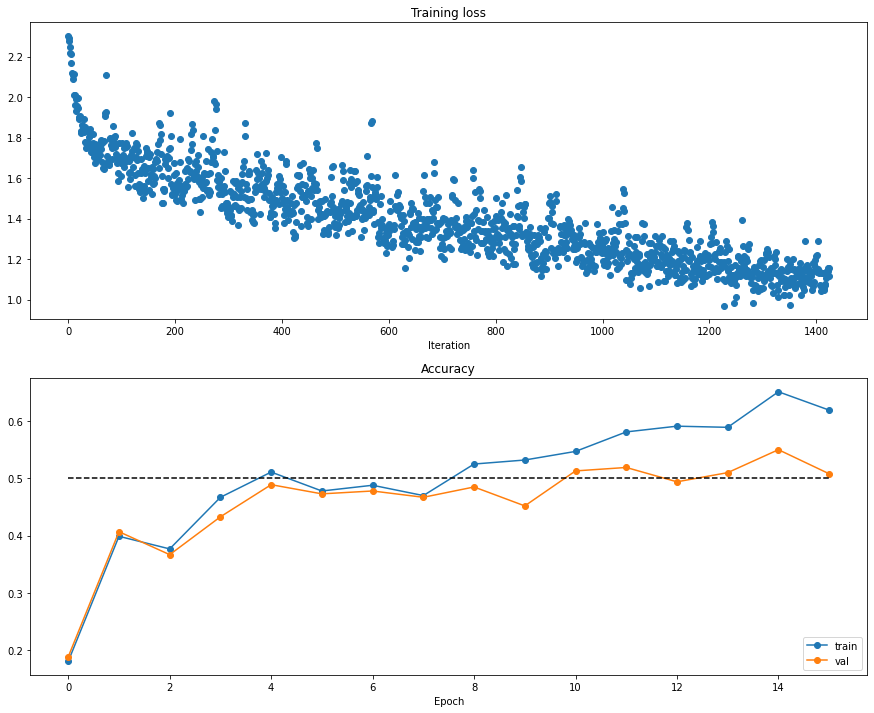

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Далее вы реализуете полносвязную сеть с произвольным количеством скрытых слоев.

Прочитайте класс `FullyConnectedNet` в файле `cs231n/classifiers/fc_net.py`.

Реализуйте инициализацию, прямой проход и обратный проход. На данный момент не беспокойтесь о реализации dropout или batch/layer нормализации; мы добавим эти функции в ближайшее время.

## Initial loss and gradient check

В качестве проверки работоспособности запустите следующее, чтобы проверить начальные потери (initial loss) и проверку градиента сети как с регуляризацией, так и без нее. Первоначальные потери кажутся разумными?

Для проверки градиента вы должны ожидать увидеть ошибки около 1e-7 или меньше.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 6.86e-09
W2 relative error: 3.52e-08
W3 relative error: 1.32e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


В качестве еще одной проверки работоспособности убедитесь, что вы можете переобучиться на  небольшом наборе данных из 50 изображений. Сначала мы попробуем трехслойную сеть со 100 единицами в каждом скрытом слое. В следующей ячейке настройте **скорость обучения** и **масштаб инициализации веса**, чтобы достичь 100% точности обучения в течение 20 эпох.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.114000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.156000
(Epoch 2 / 20) train acc: 0.460000; val_acc: 0.162000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.183000
(Epoch 4 / 20) train acc: 0.720000; val_acc: 0.176000
(Epoch 5 / 20) train acc: 0.760000; val_acc: 0.189000
(Iteration 11 / 40) loss: 0.835211
(Epoch 6 / 20) train acc: 0.580000; val_acc: 0.182000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.185000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.168000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.164000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.172000
(Iteration 21 / 40) loss: 0.289647
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.178000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.187000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.191000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.185000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.186000
(Iteration 31 / 40) loss: 

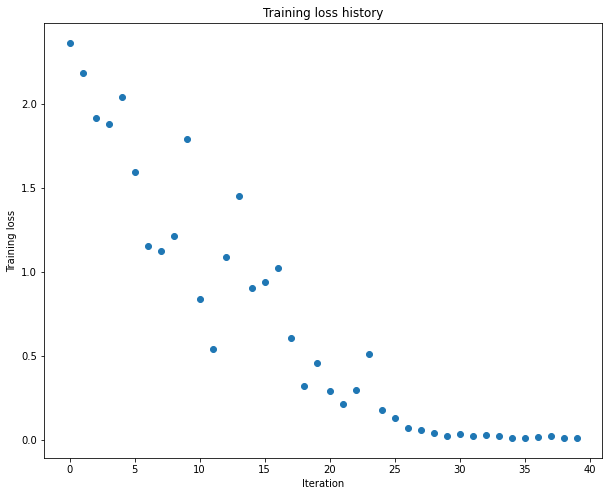

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2 # Experiment with this!
learning_rate = 1.5e-2 # Experiment with this!
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Теперь попробуйте использовать пятислойную сеть со 100 нейронами на каждом слое, чтобы переобучить 50 обучающих примеров. Опять же, вам придется настроить скорость обучения и масштаб инициализации веса, но вы сможете достичь 100% точности обучения в течение 20 эпох.

(Iteration 1 / 40) loss: 5.557032
(Epoch 0 / 20) train acc: 0.100000; val_acc: 0.091000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.114000
(Epoch 2 / 20) train acc: 0.140000; val_acc: 0.076000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.136000
(Epoch 4 / 20) train acc: 0.440000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.560000; val_acc: 0.155000
(Iteration 11 / 40) loss: 1.484811
(Epoch 6 / 20) train acc: 0.460000; val_acc: 0.156000
(Epoch 7 / 20) train acc: 0.680000; val_acc: 0.155000
(Epoch 8 / 20) train acc: 0.840000; val_acc: 0.128000
(Epoch 9 / 20) train acc: 0.840000; val_acc: 0.149000
(Epoch 10 / 20) train acc: 0.820000; val_acc: 0.177000
(Iteration 21 / 40) loss: 0.767951
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.164000
(Epoch 12 / 20) train acc: 0.900000; val_acc: 0.186000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.181000
(Epoch 14 / 20) train acc: 0.940000; val_acc: 0.165000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.162000
(Iteration 31 / 40) loss: 

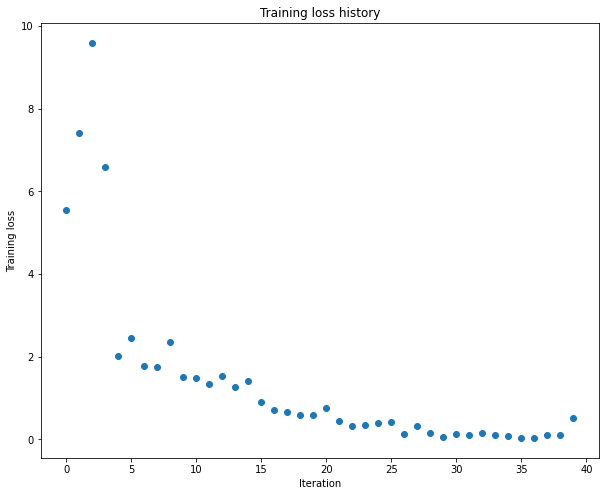

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 0.026 # Experiment with this! 0.026
weight_scale = 0.05 # Experiment with this! 0.027
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Вы заметили что-нибудь о сравнительной сложности обучения трехслойной сети по сравнению с обучением пятислойной сети? В частности, исходя из вашего опыта, какая сеть показалась более чувствительной к масштабу инициализации? Как вы думаете, почему это так?

## Answer:
Обучение 5-и слойной сети оказалось сложнее, более нестабильным. Сеть с 5-ю слоями  более чувствительна к масштабу начальной инициализации весов. При маленьком значении с.к.о начальной инициализации (по нормальному распределению с центром в 0) оказалось что сеть почти не обучается (слишком малые результаты скалярного произведения, затухающий градиент). А при увеличении с.к.о  близком к 0.1 вычисляемые значения градиентов могуть "взорваться" и вызвать переполнение.


# Update rules
До сих пор мы использовали ванильный стохастический градиентный спуск (SGD) в качестве нашего правила обновления. Более сложные правила обновления могут упростить обучение глубоких сетей. Мы реализуем несколько наиболее часто используемых правил обновления и сравним их с ванильным SGD.

# SGD+Momentum
Стохастический градиентный спуск с импульсом — это широко используемое правило обновления, которое заставляет глубокие сети сходиться быстрее, чем ванильный стохастический градиентный спуск. Дополнительную информацию см. в разделе «Обновление Momentum» по адресу http://cs231n.github.io/neural-networks-3/#sgd.

Откройте файл `cs231n/optim.py` и прочитайте документацию в верхней части файла, чтобы убедиться, что вы понимаете API. Реализуйте правило обновления SGD+momentum в функции `sgd_momentum` и выполните следующее, чтобы проверить свою реализацию. Вы должны увидеть ошибки меньше, чем e-8.

In [ ]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


После того, как вы это сделаете, запустите следующее, чтобы обучить шестислойную сеть как с SGD, так и с SGD+momentum. Вы должны увидеть, что правило обновления SGD+momentum сходится быстрее.

running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.107000
(Iteration 11 / 200) loss: 2.356069
(Iteration 21 / 200) loss: 2.214091
(Iteration 31 / 200) loss: 2.205928
(Epoch 1 / 5) train acc: 0.225000; val_acc: 0.193000
(Iteration 41 / 200) loss: 2.132095
(Iteration 51 / 200) loss: 2.118950
(Iteration 61 / 200) loss: 2.116443
(Iteration 71 / 200) loss: 2.132549
(Epoch 2 / 5) train acc: 0.298000; val_acc: 0.260000
(Iteration 81 / 200) loss: 1.977227
(Iteration 91 / 200) loss: 2.007528
(Iteration 101 / 200) loss: 2.004762
(Iteration 111 / 200) loss: 1.885342
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.287000
(Iteration 121 / 200) loss: 1.891517
(Iteration 131 / 200) loss: 1.923677
(Iteration 141 / 200) loss: 1.957743
(Iteration 151 / 200) loss: 1.966736
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.305000
(Iteration 161 / 200) loss: 1.801483
(Iteration 171 / 200) loss: 1.973780
(Iteration 181 / 200) loss: 1.666572
(Iteration 191 / 200) los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

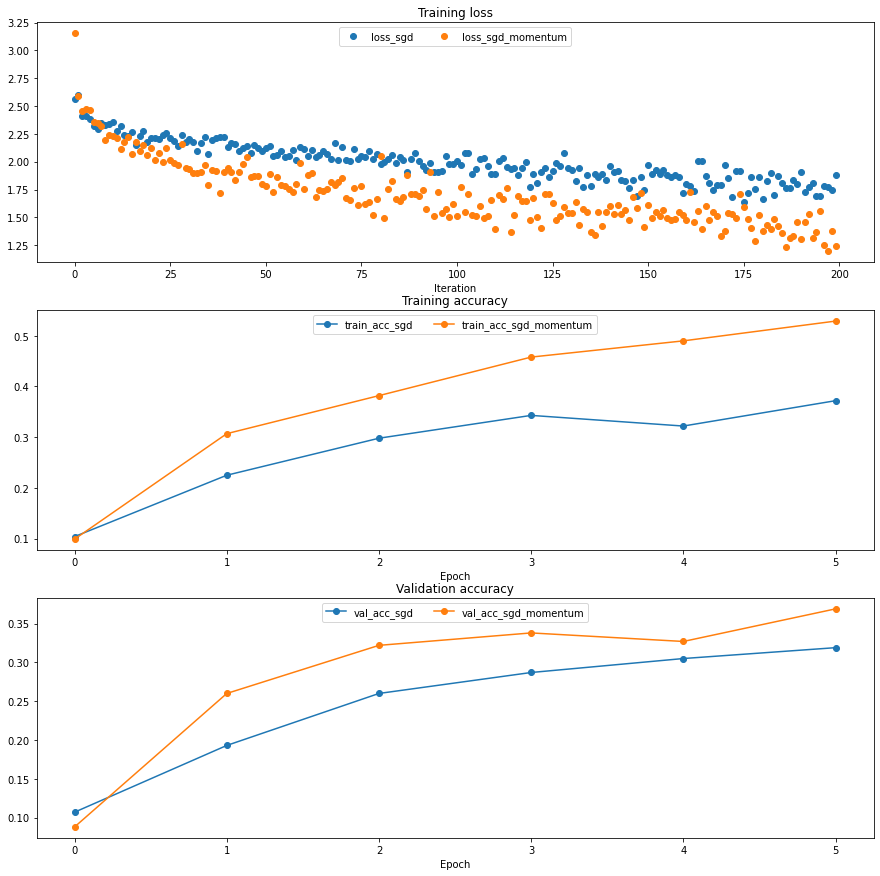

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] и Adam [2] — это правила обновления, которые устанавливают скорость обучения для каждого параметра, используя скользящее среднее вторых моментов градиентов.

В файле `cs231n/optim.py` внедрите правило обновления RMSProp в функцию `rmsprop` и внедрите правило обновления Adam в функцию `adam`, и проверьте свои реализации, используя приведенные ниже тесты. 

**ПРИМЕЧАНИЕ.** Пожалуйста, реализуйте правило обновления _complete_ Адама (с механизмом исправления смещения), а не первую упрощенную версию, упомянутую в примечаниях к курсу.


[1] Tijmen Tieleman and Geoffrey Hinton. «Лекция 6.5-rmsprop: разделите градиент на скользящее среднее его недавней величины». COURSERA: Нейронные сети для машинного обучения 4 (2012). 

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [ ]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


После того, как вы отладили свои реализации RMSProp и Adam, запустите следующее, чтобы обучить пару глубоких сетей, используя эти новые правила обновления:

running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505558
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519017
(Iteration 101 / 200) loss: 1.368522
(Iteration 111 / 200) loss: 1.470400
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199064
(Iteration 131 / 200) loss: 1.464705
(Iteration 141 / 200) loss: 1.359863
(Iteration 151 / 200) loss: 1.415069
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.382818
(Iteration 171 / 200) loss: 1.359900
(Iteration 181 / 200) loss: 1.095947
(Iteration 191 / 200) lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

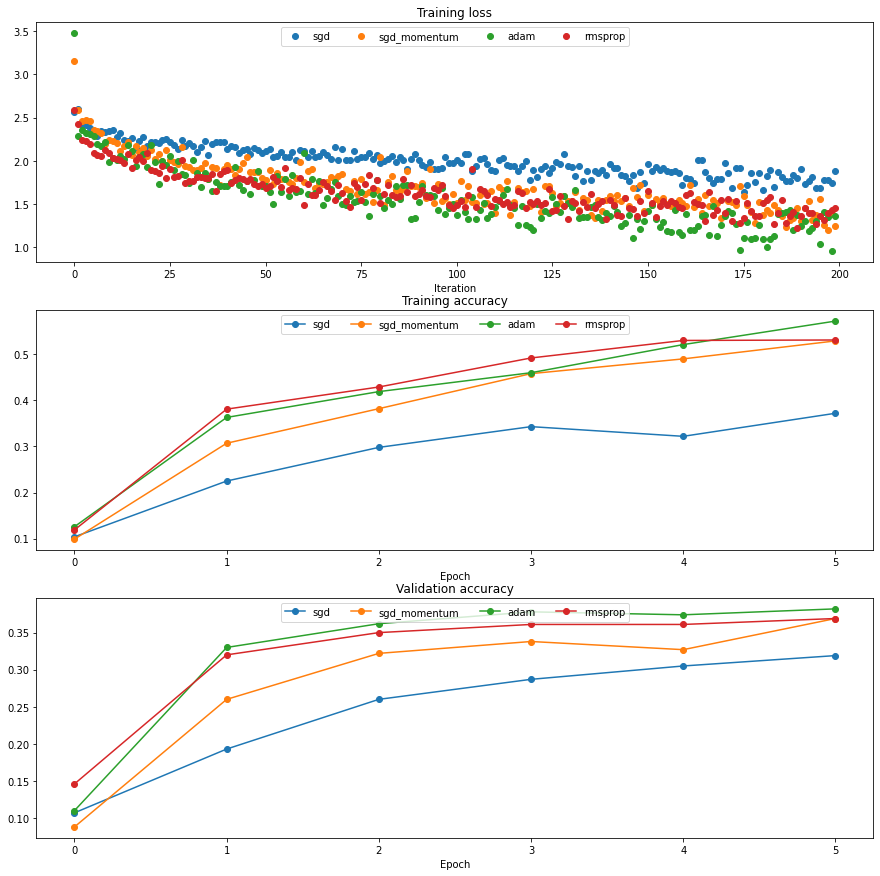

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 3:

AdaGrad, как и Adam, представляет собой метод оптимизации для каждого параметра, который использует следующее правило обновления:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```
Джон замечает, что когда он обучал сеть с помощью AdaGrad, обновления стали очень маленькими, и что его сеть обучалась медленно. Используя ваши знания правила обновления AdaGrad, как вы думаете, почему обновления станут очень маленькими? Будет ли у Adam такая же проблема?


## Answer: 
Обновления весов со временем значительно уменьшатся, так как они делятся на квадратный корень из кумулятивной суммы квадратов предыдущих значений градиента. 
У Adam обновления весов делятся на корень из v, где v - сглаженное значение суммы квадратов: `v = beta2*v + (1-beta2)*(dx**2)`, где `beta2 < 1`. В этом случае значения v не будут так быстро расти.


# Train a good model!
Обучите лучшую полносвязную модель на CIFAR-10, сохранив ее в переменной best_model. Мы требуем, чтобы вы получили по крайней мере 50% точности на проверочном наборе, используя полносвязную сеть. 

Если вы будете осторожны, вы сможете получить точность выше 55%, но мы не требуем этого для этой части и не будем присваивать за это дополнительную оценку. Позже в этом задании мы попросим вас обучить на CIFAR-10 лучшую из возможных сверточных сетей, и мы бы предпочли, чтобы вы потратили свои усилия на сверточные сети, а не на полносвязные сети. 

Возможно, вам будет полезно заполнить блокноты `BatchNormalization.ipynb` и `Dropout.ipynb` перед выполнением этой части, поскольку эти методы могут помочь вам обучить мощные модели.

In [ ]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                           #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

'''
Инициализация весов: можно использовать рандомную, так как в каждой модели будет использована нормализация по батчу/слою, что уменьшит чувствительность сети к начальной инициализации весов.
Возможные варианты BN/LN и Dropout отдельно или BN/LN + Dropout.
Алгоритмы обновления весов: adam.
Скорость обучения: подбираемый гиперпараметр. Так как будет использован адаптивный алгоритм обновления весов, методы отжига "глобальной" скорости обучения не будут использованы.
Время обучения: 10 эпох
Поиск лучших значений гиперпараметров будет производиться по рандомной сетке. 
Также следует учесть, чтобы подобранные оптимальные значения гиперпараметров не попали на границы сетки возможных значений гиперпараметров.
Валидация: оценка качества обучения сети при текущих значений гиперпараметров будет производиться на отложенной заранее выборке. 
Перекрестная проверка не будет использована, так как имеется большой массив данных.
Тестирование наилучшей модели будет производиться на множестве из 1000 картинок.
'''

def get_random_params_2(lr_min,lr_max, hds_min, hds_max, rg_streng_min, rg_streng_max):
  lr = 10 ** np.random.uniform(lr_min, lr_max)
  hds = np.random.randint(hds_min,hds_max)
  reg_strength = 10 ** np.random.uniform(rg_streng_min, rg_streng_max)
  return lr, hds, reg_strength


network_depths = [5, 10]
normalization_with_dropout = [False, True] # будет ли использована нормализация одновременно с Dropout

solver_best_model = None
best_val_acc = -1

for norm_with_drop in normalization_with_dropout:
  for net_depth in network_depths:
    for i in range(0,10):
      lr, hidden_size, reg_strength = get_random_params_2(-5,-1, 100, 500, -5, -1)
      p = 1
      if (norm_with_drop):
        p = 0.5
      model = FullyConnectedNet(hidden_dims = net_depth*[hidden_size], dropout = p, normalization = "layernorm", reg = reg_strength)
      solver = Solver(model, data,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    lr_decay=1,
                    num_epochs=10, batch_size=200,
                    verbose = False)
      solver.train()
      val_acc = solver.best_val_acc

      if val_acc > best_val_acc:
        solver_best_model = solver
        best_val_acc = val_acc

      print('dropout with norm %s | net depth %d | hd size %d | lr %e | reg %e | val accuracy: %f' % (
          norm_with_drop, net_depth, hidden_size, lr, reg_strength, val_acc))
 
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

dropout with norm False | net depth 5 | hd size 450 | lr 8.392950e-05 | reg 3.771403e-02 | val accuracy: 0.549000
dropout with norm False | net depth 5 | hd size 230 | lr 3.186220e-05 | reg 2.213222e-02 | val accuracy: 0.537000
dropout with norm False | net depth 5 | hd size 320 | lr 1.482994e-05 | reg 1.450722e-05 | val accuracy: 0.535000
dropout with norm False | net depth 5 | hd size 113 | lr 4.050184e-03 | reg 9.701168e-05 | val accuracy: 0.512000
dropout with norm False | net depth 5 | hd size 411 | lr 3.944375e-04 | reg 1.914776e-05 | val accuracy: 0.562000
dropout with norm False | net depth 5 | hd size 365 | lr 9.451219e-04 | reg 3.261251e-03 | val accuracy: 0.502000
dropout with norm False | net depth 5 | hd size 110 | lr 6.034335e-05 | reg 6.209777e-02 | val accuracy: 0.557000
dropout with norm False | net depth 5 | hd size 115 | lr 1.248299e-04 | reg 2.128245e-02 | val accuracy: 0.537000
dropout with norm False | net depth 5 | hd size 228 | lr 1.118171e-04 | reg 6.733081e-02

In [ ]:
print('best validation accuracy achieved during validation: %f' % best_val_acc)

best validation accuracy achieved during validation: 0.562000


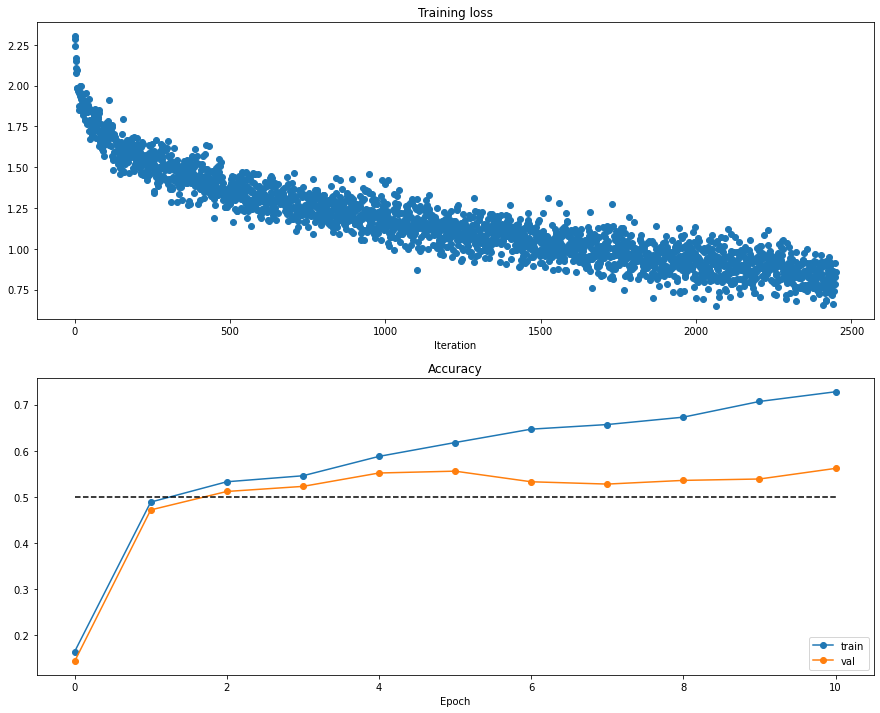

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver_best_model.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver_best_model.train_acc_history, '-o', label='train')
plt.plot(solver_best_model.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver_best_model.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [ ]:
final_model = FullyConnectedNet(hidden_dims = 5*[411], dropout = 1, normalization = "layernorm", reg = 1.914776e-05)
final_solver = Solver(final_model, data,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 3.944375e-04,
                    },
                    lr_decay=1,
                    num_epochs=20, batch_size=200,
                    verbose = False)
final_solver.train()

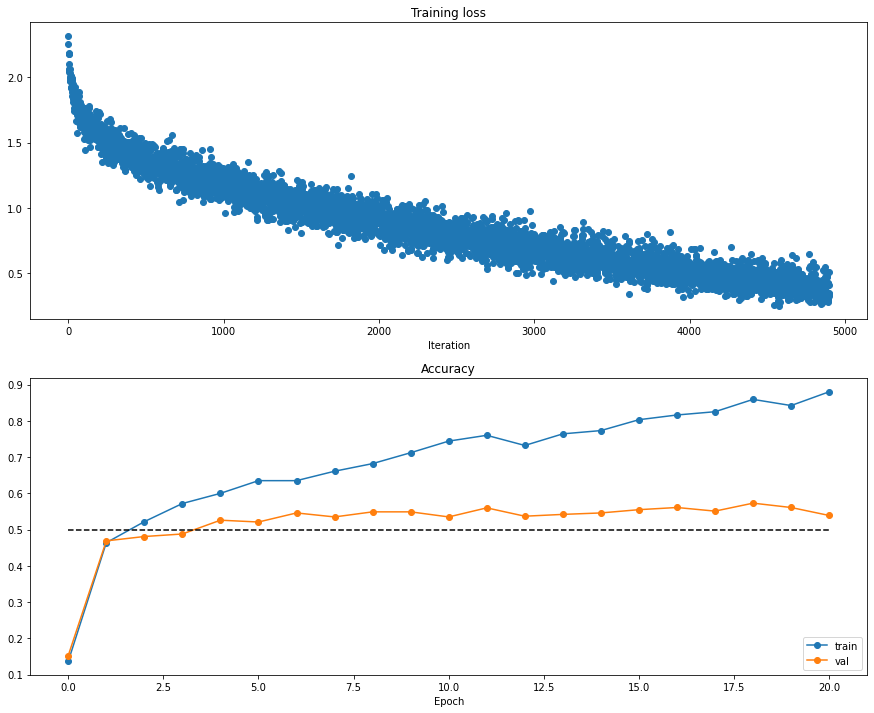

In [ ]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(final_solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(final_solver.train_acc_history, '-o', label='train')
plt.plot(final_solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(final_solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [ ]:
final_model = FullyConnectedNet(hidden_dims = 5*[411], dropout = 1, normalization = "layernorm", reg = 1.914776e-05)
final_solver = Solver(final_model, data,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 3.944375e-04,
                    },
                    lr_decay=1,
                    num_epochs=11, batch_size=200,
                    verbose = False)
final_solver.train()

# Test your model!
Запустите свою лучшую модель на проверочных и тестовых наборах. Вы должны достичь точности выше 50% на проверочном наборе.

In [ ]:
y_test_pred = np.argmax(final_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(final_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.57
Test set accuracy:  0.539
